### <span style="color:brown">Notebook Instructions</span>

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i>  Assuming, you have Anaconda or some Python environment installed on your system, <span style="color:#FFFF00; background:#00C000"> <b> you need to install Keras library. </b>. </i>
- <i> <span style="color:#00C000"> DNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>



### <span style="color:brown">Data Pre- Processing</span>

In this block of code we have downloaded the data and scaled it, just as we did in the DNN model.

In [1]:
from nsepy import get_history
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

start = date(2015,1,1)
end= date.today()

data = get_history(symbol="SBIN", start=start, end=end)

max_=data[['Open','High','Low','Close']].max().max()
min_=data[['Open','High','Low','Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X2=scl.fit_transform(data[['Volume']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-03-08,SBIN,EQ,281.75,0.657966,0.669786,0.646885,281.50,0.654765,282.38,0.068613,5.631654e+14,132214,7142794,0.3582
2019-03-11,SBIN,EQ,281.20,0.674957,0.693179,0.666092,286.95,0.685053,287.26,0.080078,6.587152e+14,133900,9195175,0.4010
2019-03-12,SBIN,EQ,287.35,0.694164,0.697611,0.677173,287.30,0.682837,287.68,0.072008,5.991832e+14,152809,9436728,0.4531
2019-03-13,SBIN,EQ,286.90,0.688747,0.719773,0.672002,293.85,0.713617,288.93,0.083126,6.855126e+14,129887,9798889,0.4130
2019-03-14,SBIN,EQ,293.15,0.720266,0.721251,0.701798,292.10,0.707461,292.34,0.054112,4.725415e+14,121789,5575090,0.3449


You can see that the OHLCV values have been updated

### <span style="color:brown"> Creating the input and target features

Now,we will create a feature data set called  <font color =red>X</font> which will be used to create the input for the LSTM model.<br> 

Next, we create a dataset called <font color =red>y</font> which will contain the future close values.<br>

The model will train to predict these values future close prices.

In [2]:
X=data[['Open','High','Low','Close','Volume']]
y=data.Last.shift(-1)

In this example, we have taken a timestep of 1 day to create the input data. This is very less compared to the 20 days data that we would have to give as input for an RNN. But you will be able to see that the LSTM is able to produce similar, if not better results, when compared to the RNN.

In [3]:
timestep=1
X_list=[]
y_list=[]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    y_list.append(y.iloc[i:i+timestep].values)

In [4]:
test_size=60
X_train=np.array(X_list[:-test_size])
y_train=np.expand_dims(np.array(y_list[:-test_size]),axis=2)
X_test=np.array(X_list[-test_size:])
y_test=np.expand_dims(np.array(y_list[-test_size:]),axis=2)

### <span style="color:brown">Creating an LSTM model

First we import the necessary modules for the model from the keras library

In this model, I have added a dropout layer with a 80% drop ratio. If you choose a model that it is not very deep then the chances of over-fitting are very less and you may not need a dropout layer. 

In [5]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
# Please note that the number of neurons used in LSTM model is lesser than those in the RNN model
neurons=200
act='tanh'
dropout_ratio=0.80

Using TensorFlow backend.


Let us begin to build the model, as you might recall the first layer will always be a sequential one. Followed by an LSTM in this case, as we want to test a simple LSTM model to check the accuracy.

After this, I have added a few Dense layers (fully connected Neural Network) along with the dropout layers.

As the depth of the model increases, the model's ability to create complex features also increases. But, this often results in overfitting.

In [6]:
model=Sequential()
model.add(LSTM(4,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Dense(neurons,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*2,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*3,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*4,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*5,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])

### <span style="color:brown"> Saving and loading the model

In Keras, we can save the best weights of the model by creating a checkpoint during the training of the model. To create a checkpoint, we specify the metric that needs to be monitored and saved accordingly. In this example, I have passed the validation set loss as the monitoring parameter, and specified the mode of saving as 'auto'. This means that the model will save the weights of the network whenever a now low value for the validation loss is generated. 

I have specified the file path as LSTM-weights-best.hdf5 to save the weights of the model.

The verbose=1 parameter defines how much information about every batch training needs to be printed

#### We strongly encourage you to change all the parameters discussed above to create your own models and test them out.

Also, please be reasonable in specifying the depth and number of neurons in a model, else you may not get a result in reasonable time.

In [7]:
filepath="LSTM-weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now let us visualize our model.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 4)              160       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 200)            1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 400)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 400)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 600)            240600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 600)            0         
__________

Now, its time to train the model.

While training the model we have to specify the size of the batch, this indicates to the model how many train samples it should take in a single batch while training.

The validation split randomly splits the train data to verify the performance of the model on untrained data.

Epochs are the number of runs the model needs to make for the convergence of train and validation losses.

Once we have generated the best weigths and saved them using the callback feature, we would want our final model to have this best weigths fitted before making the predictions on the test data. So, we load these weights using the load_weights function.

In [9]:
model.load_weights("LSTM-weights-best.hdf5")

### <span style="color:brown"> Predicting the Close Prices

Now, we will create a list that would hold the LSTM model's predicitons on the test data.

After this, we create a dataframe called performance that contains the actual close values and the predictied close values to analyze the predictions

In [10]:
predict_close=[]
predict_close = list(model.predict(X_test))


In [11]:
predicted_close=[]
for i in range(len(y_test)):
    predicted_close.append((predict_close[i][0][0]))
predicted_close

[291.92792,
 292.22437,
 294.56393,
 301.0949,
 297.53668,
 295.1181,
 295.1104,
 294.9052,
 295.21954,
 297.64313,
 298.4237,
 299.5714,
 297.50583,
 294.36725,
 298.90118,
 298.70068,
 303.17755,
 303.42126,
 304.03973,
 302.77255,
 301.82626,
 302.4806,
 303.3684,
 299.26385,
 297.78098,
 295.26102,
 292.81686,
 290.80078,
 290.9702,
 290.2015,
 281.77515,
 280.7521,
 290.45312,
 295.099,
 290.65436,
 285.80865,
 289.3047,
 290.92746,
 291.6569,
 290.0191,
 281.83493,
 272.6285,
 266.71875,
 265.1516,
 263.29767,
 261.90356,
 263.27142,
 265.50616,
 266.30878,
 267.01514,
 266.8835,
 264.4429,
 266.57306,
 266.88794,
 267.6203,
 271.72003,
 276.76337,
 281.0395,
 282.82388,
 290.5788]

In [12]:
actual_close=[]
for i in range(len(y_test)):
    actual_close.append((y_test[i][0][0]))
actual_close

[293.9,
 299.5,
 294.0,
 292.0,
 293.5,
 294.55,
 293.3,
 294.45,
 295.65,
 300.7,
 293.8,
 291.05,
 297.3,
 296.55,
 305.5,
 304.75,
 305.4,
 301.65,
 300.5,
 301.65,
 303.0,
 297.4,
 295.3,
 292.3,
 290.85,
 286.2,
 288.15,
 285.65,
 282.5,
 281.45,
 287.35,
 294.8,
 282.6,
 284.1,
 284.5,
 289.45,
 287.0,
 286.55,
 280.45,
 275.1,
 267.0,
 267.5,
 262.8,
 259.5,
 262.75,
 268.0,
 268.0,
 270.8,
 270.15,
 266.15,
 267.6,
 269.15,
 272.85,
 275.95,
 278.1,
 281.95,
 281.5,
 286.95,
 287.3,
 nan]

In [13]:
performance=pd.DataFrame([list(predicted_close),list(actual_close)])

In [14]:
performance=performance.T

In [15]:
performance.columns=['Predicted','Actual']
Spread=performance.Actual-performance.Predicted


In [16]:
performance.tail()

,Predicted,Actual
55,271.720032,281.95
56,276.763367,281.50
57,281.039490,286.95
58,282.823883,287.30
59,290.578796,NaN


Now we will plot and see how the spread between the Actual and Predicted prices behaves. If the spread is mean reverting, then we can use this knowledge to create good entry and exit points for already exiting trades, or we enter new positions. 

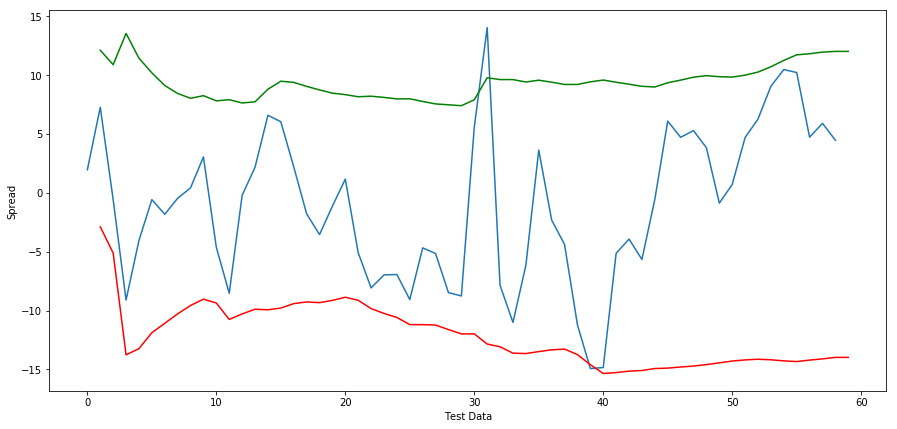

In [17]:
# Here s stands for the standard deviation range for the spread, beyond which we will consider the entry and exit positions
# Feel free to change this s value to generate different signals
s=2
plt.figure(figsize=(15,7))
plt.plot(Spread)
plt.plot(Spread.expanding().mean()+s*Spread.expanding().std(),c='g')
plt.plot(Spread.expanding().mean()-s*Spread.expanding().std(),c='r')
plt.ylabel('Spread')
plt.xlabel('Test Data')
plt.show()

### <span style="color:brown"> Visualizing and comparing the performance

Now, let us plot the predicted and actual values of the close prices.

In this strategy, we have generated a buy signal everytime the spread value has gone below the lower standard deviation line.
Conversely, we have generated a sell signal everytime the spread value has gone above the upper standard deviation line.

####  Please note: The strategy given here is a mean reverting model that could be used for paper trading. Please do not use this in real trading without extensive backtesting.

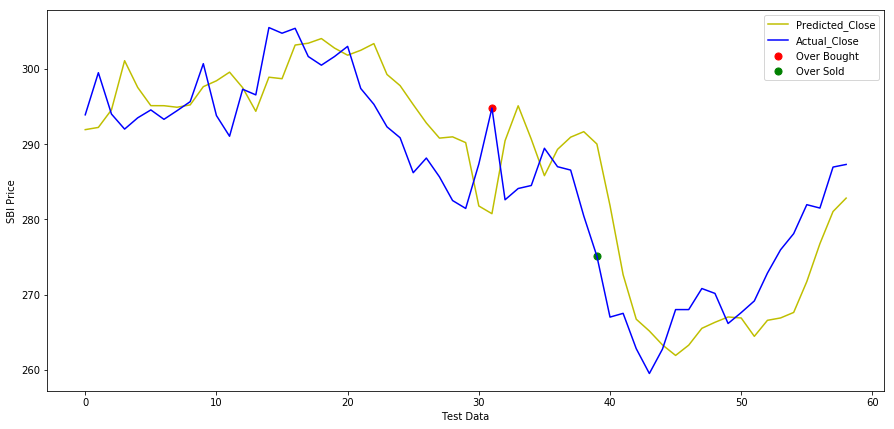

In [18]:
plt.figure(figsize=(15,7))
# Plot the predicted and actual prices for comparison
plt.plot(performance.Predicted.iloc[:-1],c='y')
plt.plot(performance.Actual,c='b')
# Plot the sell signlas wherever the Spread is above the upper standard deviation band
plt.scatter(performance.Actual[(Spread>Spread.expanding().mean()+s*Spread.expanding().std())].index,
            performance.Actual[(Spread>Spread.expanding().mean()+s*Spread.expanding().std())],c='r',s=50)
# Plot the buy signlas wherever the Spread is below the lower standard deviation band
plt.scatter(performance.Actual[(Spread<Spread.expanding().mean()-s*Spread.expanding().std())].index,
            performance.Actual[(Spread<Spread.expanding().mean()-s*Spread.expanding().std())],c='g',s=50)
plt.legend(['Predicted_Close','Actual_Close','Over Bought','Over Sold'])
plt.ylabel('SBI Price')
plt.xlabel('Test Data')
plt.show()


### Conclusion

We can see from the above graph that whenever the sell signals are generated, the market has either turned sideways/ neutral, or  shown a sharp reversal. 